# Обзор и первичное исследование данных

## Описание проекта


Данные: данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Цель: определить рекламные источники, которые окупаются и которые нет.

Изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

## Описание данных

**visits_log.csv** - лог сервера с информацией о посещениях сайта.

Структура visits_log.csv
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.


**orders_log.csv** — информацию о заказах. 

Структура orders_log.csv
- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

**costs.csv** — информацию о расходах на маркетинг.

Структура costs.csv
- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

## Импорт библиотек и данных

In [140]:
import pandas as pd
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import datetime as dt

In [2]:
visits = pd.read_csv('https://.../visits_log.csv') 
orders = pd.read_csv('https://.../orders_log.csv')
costs = pd.read_csv('https://.../costs.csv')

## Изучение и предобработка данных 

Изучим каждую таблицу отдельно и сразу сделаем предобработку в случае необходимости.

### visits

In [3]:
visits.sample(5, random_state = 42)

,Device,End Ts,Source Id,Start Ts,Uid
327288,desktop,2017-06-07 12:50:00,4,2017-06-07 12:48:00,10569978864840669622
37842,touch,2017-07-22 11:47:00,3,2017-07-22 11:44:00,4706312912512076919
251085,desktop,2017-07-05 23:10:00,10,2017-07-05 22:46:00,2649635917176545830
321132,touch,2017-12-08 16:02:00,4,2017-12-08 16:01:00,1130562819482642606
247808,desktop,2018-03-28 14:06:00,2,2018-03-28 14:05:00,11413415170783315413


Отредактируем названия столбцов и их порядок в таблице

In [4]:
def columns(df):
    df.columns = ((df.columns.str.lower()).str.replace(' ', '_')).str.strip()
    print(df.columns)

In [5]:
columns(visits)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')


In [6]:
visits = visits[['uid', 'device', 'source_id', 'start_ts', 'end_ts']]

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uid        359400 non-null  uint64
 1   device     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   end_ts     359400 non-null  object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пропуски в данных отсутствуют. 

Приведем тип данных в `start_ts` и `end_ts` к типу "дата".

In [8]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        359400 non-null  uint64        
 1   device     359400 non-null  object        
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   end_ts     359400 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


После преобразования к соответствующему типу данных, можно посмотреть на статистическую информацию:

In [10]:
visits[['start_ts', 'end_ts']].describe()

,start_ts,end_ts
count,359400,359400
unique,224303,224760
top,2017-11-24 16:06:00,2017-11-24 16:51:00
freq,19,23
first,2017-06-01 00:01:00,2017-06-01 00:02:00
last,2018-05-31 23:59:00,2018-06-01 01:26:00


В таблице есть данные, относящиеся в июню 2018 года, хотя заявлено, что данные у нас до 31.05.2018 г. Посмотрим, много ли данных на 01.06.2018 г.

In [11]:
visits.query('end_ts == "2018-06-01 01:26:00"')

,uid,device,source_id,start_ts,end_ts
342205,13670831770959132678,touch,1,2018-05-31 23:44:00,2018-06-01 01:26:00


Всего одна строка, при этом дата начала сессии: 31.05.2018 (что ожидаемо, т.к. в столбце `start_ts` самая поздняя дата - 31.05.2018). Всё ок. 

В таблице есть столбец с данными, похожими на категориальные, `device`. Посмотрим, много ли у нас видов устройств, которые используют пользователи для перехода на наш ресурс.

In [12]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

Обязательно проверяем на дубликаты.

In [13]:
visits.duplicated().sum()

0

Грубых дубликатов наша таблицы `visits` не содержит. 


Таблица `visits` содержит данные о 359 тысячах сессий пользователей c 01 июня 2017 г. по 31 мая 2018 г., т.е. у нас есть данные за 1 год. Пропусков в данных нет, типы данных после обработки соответствуют сути содержащихся данных.

### costs

In [14]:
costs.sample(5, random_state = 42)

,source_id,dt,costs
1642,5,2017-12-08,174.57
727,3,2017-06-02,314.22
498,2,2017-10-14,131.73
1463,5,2017-06-12,64.60
564,2,2017-12-19,166.40


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [16]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Типы данных теперь в порядке. Посмотрим на статистику по датам.

In [18]:
costs['dt'].describe()

count                    2542
unique                    364
top       2017-06-28 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Данные за исследуемый период, дат, выходящих за пределы - нет. 

Оценим статистические данные по числовым данным из столбца `costs`.

In [19]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

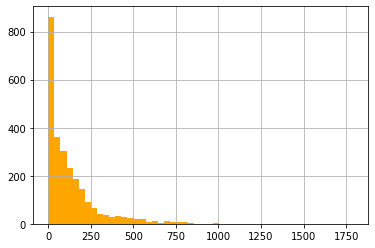

In [20]:
costs['costs'].hist(bins=50, color='orange')
plt.show()

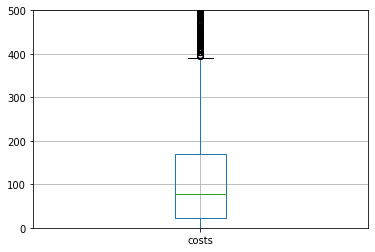

In [21]:
costs.boxplot(['costs'])
plt.ylim(0, 500)
plt.show()

Наши данные сильно скошены вправо, что видно и по статистическим данных, и по распределению и по диаграмме размаха. В таком случае лучше в качестве средней меры использовать медиану. Учтем это, если в ходе исследования нужно будет использовать средние значения расходов на рекламу. 

Проверка на дубликаты:

In [22]:
costs.duplicated().sum()

0

Таблица `costs` содержит данные о 2.5 тысячах рекламных кампаний c 01 июня 2017 г. по 31 мая 2018 г., пропусков и дубликатов в данных нет, типы данных соответствуют содержащимся данным.

В расходах на маркетинговые кампании довольно много выбросов, а также маленьких сумм, что видно по гистограмме распределения и диаграмме размаха. Возможно, что данные приведены в расчете на каждый показ рекламы/клик по ссылке или что-то подобное. 

### orders

In [23]:
orders.sample(5, random_state = 42)

,Buy Ts,Revenue,Uid
24526,2017-12-17 01:14:00,1.34,10376975812117698225
43841,2018-04-12 09:23:00,7.33,12161916031543310791
42778,2018-03-29 23:51:00,1.17,15888599410730719596
9317,2017-09-27 14:32:00,0.98,11785751562598603943
1655,2017-06-19 18:39:00,19.86,13203527169223228134


Так же отредактируем названия столбцов

In [24]:
columns(orders)

Index(['buy_ts', 'revenue', 'uid'], dtype='object')


In [25]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Приведем тип данных в соответствие 

In [26]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [27]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


И оценим числовые данные из столбца `revenue`

In [28]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

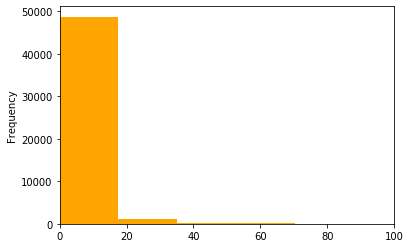

In [29]:
orders['revenue'].plot.hist(bins=150, color='orange')
plt.xlim(0, 100)
plt.show()

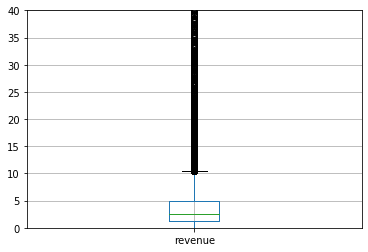

In [30]:
orders.boxplot(['revenue'])
plt.ylim(0, 40)
plt.show()

Суммы заказов с основном небольшие, до 18 y.e., так же, как и с расходами на рекламу, присутствует сильная скошенность данных. Также в расчетах нужно будет использовать медиану. 

In [31]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Период отличается от периода в данных из таблиц `visits` и `costs` на 1 день - 2018-06-01. Посмотрим на данные за этот день. 

In [32]:
orders.query('buy_ts >= "2018-06-01 00:00:00"')

,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


Всего одна строчка, удалим её, чтобы периоды совпадали во всех таблицах. 

In [33]:
print('Кол-во строк ДО удаления:', orders.shape[0])

orders = orders.query('buy_ts < "2018-06-01 00:00:00"')

print('Кол-во строк ПОСЛЕ удаления:', orders.shape[0])

Кол-во строк ДО удаления: 50415
Кол-во строк ПОСЛЕ удаления: 50414


In [34]:
orders.duplicated().sum()

0

Таблица `orders` содержит данные о 50 тысячах заказов c 01 июня 2017 г. по 31 мая 2018 г., пропусков в данных нет, типы данных соответствуют содержащимся данным.

Данные о доходах содержат много выбросов. Меры центральных тенденций сильно отличаются (медиана - 2.5, среднее - 4.9), отклонение для таких средних значений довольно большой - 21.8, что также свидетельствует о большом размахе данных. 

# Метрики


## Продуктовые метрики

### Пользовательские метрики (DAU, WAU, MAU)

Для расчета пользовательской активности преобразуем даты начала сессий пользователей.

In [35]:
visits['start_day'] = visits['start_ts'].astype('datetime64[D]')
visits['start_week'] = visits['start_ts'].astype('datetime64[W]')
visits['start_month'] = visits['start_ts'].astype('datetime64[M]')
visits.head()

,uid,device,source_id,start_ts,end_ts,start_day,start_week,start_month
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,2017-12-14,2017-12-01
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,2018-02-15,2018-02-01
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,2018-05-17,2018-05-01
4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,2017-12-21,2017-12-01


In [36]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uid          359400 non-null  uint64        
 1   device       359400 non-null  object        
 2   source_id    359400 non-null  int64         
 3   start_ts     359400 non-null  datetime64[ns]
 4   end_ts       359400 non-null  datetime64[ns]
 5   start_day    359400 non-null  datetime64[ns]
 6   start_week   359400 non-null  datetime64[ns]
 7   start_month  359400 non-null  datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(1), uint64(1)
memory usage: 21.9+ MB


Рассчитаем метрики пользовательской активности.

In [37]:
DAU = visits.groupby('start_day').agg({'uid': 'nunique'}).reset_index()
WAU = visits.groupby('start_week').agg({'uid': 'nunique'}).reset_index()
MAU = visits.groupby('start_month').agg({'uid': 'nunique'}).reset_index()

Среднее значение DAU: 908


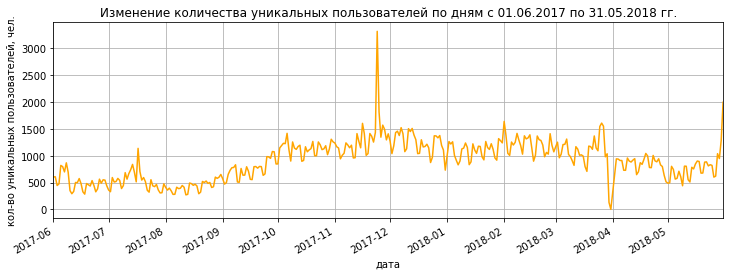

In [38]:
print('Среднее значение DAU: {}'.format(int(round(DAU.mean(),0))))

DAU.plot(x='start_day', y='uid',
         figsize=(12, 4), xlim=('2017-06-01', '2018-05-31'), 
         grid=True, legend=False, color='orange',
         title='Изменение количества уникальных пользователей по дням с 01.06.2017 по 31.05.2018 гг.')
plt.xlabel('дата') 
plt.ylabel('кол-во уникальных пользователей, чел.') 
plt.show()

В день наш ресурс посещает в среднем 908 уникальных пользователей. 
Рост в течение года приходится на осень, наибольший интерес пользователи проявляют к концу ноября, затем начинается постепенное снижение к летнему сезону, что интуитивно понятно и объяснимо, т.к. лето - традиционно "мертвый сезон" для культурных событий и мероприятий. 

Среднее значение DAU: 908


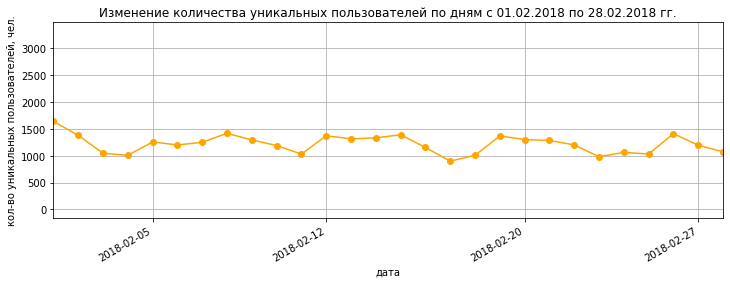

In [39]:
print('Среднее значение DAU: {}'.format(int(round(DAU.mean(),0))))

DAU.plot(x='start_day', y='uid',
         figsize=(12, 4), xlim=('2018-02-01', '2018-02-28'), 
         grid=True, legend=False, style='-o', color='orange',
         title='Изменение количества уникальных пользователей по дням с 01.02.2018 по 28.02.2018 гг.')
plt.xlabel('дата') 
plt.ylabel('кол-во уникальных пользователей, чел.') 
plt.xticks(['2018-02-05', '2018-02-12', '2018-02-20', '2018-02-27'])
plt.show()

Если посмотреть на колебания в течение недели, то более высокие значения наблюдаем с воскресенья по среду-четверг, видимо, люди еще в начале недели планируют свой досуг на выходные или стараются скрасить боль начала недели мечтами об отдыхе и предстоящих выходных (*шутка*).

Среднее значение WAU: 5724


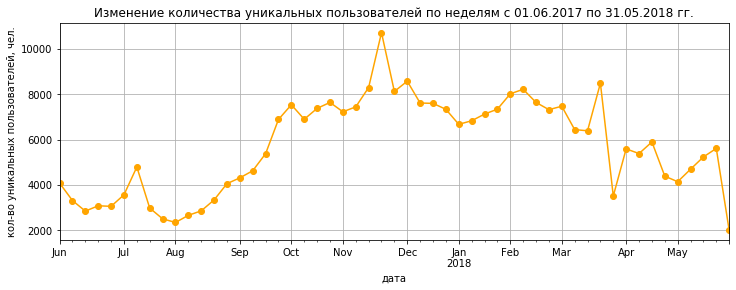

In [40]:
print('Среднее значение WAU: {}'.format(int(round(WAU.mean(),0))))

WAU.plot(x='start_week', y='uid',
         figsize=(12, 4), xlim=('2017-06-01', '2018-05-31'), 
         grid=True, legend=False, style='-o', color='orange',
         title='Изменение количества уникальных пользователей по неделям с 01.06.2017 по 31.05.2018 гг.')
plt.xlabel('дата') 
plt.ylabel('кол-во уникальных пользователей, чел.') 
plt.show()

Количество уникальных пользователей в течение недели в среднем 5,7 тысяч. 
На графике уже более четко прослеживается рост активности осенью и спад к летним месяцам, которые мы отмечали ранее на графике DAU.

Среднее значение MAU: 23228


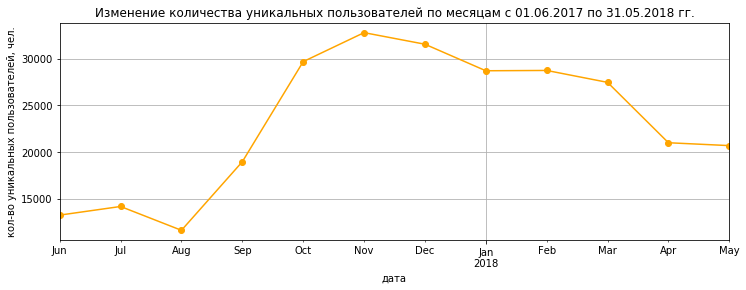

In [41]:
print('Среднее значение MAU: {}'.format(int(round(MAU.mean(),0))))

MAU.plot(x='start_month', y='uid',
         figsize=(12, 4), xlim=('2017-06-01', '2018-05-31'), 
         grid=True, legend=False, style='-o', color='orange',
         title='Изменение количества уникальных пользователей по месяцам с 01.06.2017 по 31.05.2018 гг.')
plt.xlabel('дата') 
plt.ylabel('кол-во уникальных пользователей, чел.') 
plt.show()

В месяц "Афишу" посещает 23 тысячи уникальных пользователей, наверное, это неплохой результат... 
Опять же из-за укрупнения данных "шумы" ушли еще больше и "капитан очевидность" сообщает о снижении активности летом и ростом активности к зиме. 

In [42]:
print('sticky_factor_wau:', round((DAU.mean() / WAU.mean()), 2))            
print('sticky_factor_mau:', round((DAU.mean() / MAU.mean()), 2))

sticky_factor_wau: uid    0.16
dtype: float64
sticky_factor_mau: uid    0.04
dtype: float64


**Вывод**

На графиках четко прослеживается сезонность посещения "Афиши". Летом все хотят отдыхать на природе и в отпусках на морях, что, конечно же, отражается на интересе к культурным мероприятиям и, соответственно, к нашему ресурсу. Зато осенью, когда погода начинает портиться, интерес к "Афише" растет, намного приятнее проводить досуг в кино, театре или на концерте любимого исполнителя.  
Судя по месячному sticky factor пользовательская аудитория постоянно обновляется (4 %), что, в принципе, ожидаемо, редко встретишь человека, кто каждый день ходит на культурные мероприятия в течение всего года, но в течение недели sticky factor составляет 16 %, что является не самым плохим показателем для нынешних реалий. 

### Типичная пользовательская сессия

#### Среднее кол-во посещений за день

Рассчитаем, сколько в среднем сессий у одного пользователя за день, для этого сгруппируем данные о визитах на сайт по кол-ву уникальных пользователей за каждый день. 

In [43]:
session_per_user = visits.groupby('start_day').agg({'uid': ['count', 'nunique']}).reset_index()
session_per_user.columns = ['start_day', 'n_session', 'n_users']
session_per_user['session_per_user'] = session_per_user['n_session']/session_per_user['n_users']

In [44]:
session_per_user.head(5)

,start_day,n_session,n_users,session_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024


In [45]:
session_per_user['session_per_user'].describe()

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
Name: session_per_user, dtype: float64

Среднее кол-во сессий: 1


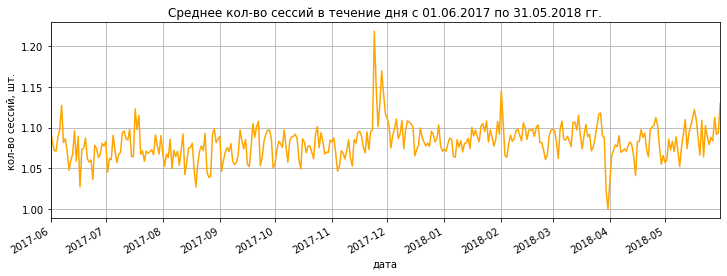

In [46]:
print('Среднее кол-во сессий: {}'.format(int(round(session_per_user['session_per_user'].mean(),0))))

session_per_user.plot(x='start_day', y='session_per_user', 
                      figsize=(12, 4), 
                      xlim=('2017-06-01', '2018-05-31'), 
                      grid=True, legend=False, color='orange', 
                      title='Среднее кол-во сессий в течение дня с 01.06.2017 по 31.05.2018 гг.')
plt.xlabel('дата')
plt.ylabel('кол-во сессий, шт.')
plt.show()


**Вывод**

Пользователи редко заходят на сайт по несколько раз на дню, среднее кол-во сессий - 1. Что в принципе и понятно, обычно на сайты-агрегаторы заходят уже непосредственно для покупки билетов.
Хотя к концу года показатель немного растет, среднее значение начинает доходить до 1.2, то есть к Новому году появляются "нерешительные" покупатели... возможно это как раз связано с новогодними праздниками: как подготовкой подарков, которыми могут быть и билеты на мероприятия, так и выбором мероприятий для проведения досуга в непосредственно сами "каникулы". 

#### Средняя продолжительность сессии



In [47]:
visits['duration_ts_min'] = ((visits['end_ts'] - visits['start_ts']).dt.seconds)/60

In [48]:
visits.head()

,uid,device,source_id,start_ts,end_ts,start_day,start_week,start_month,duration_ts_min
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,2017-12-14,2017-12-01,18.0
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,2018-02-15,2018-02-01,28.0
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01,0.0
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,2018-05-17,2018-05-01,24.0
4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,2017-12-21,2017-12-01,0.0


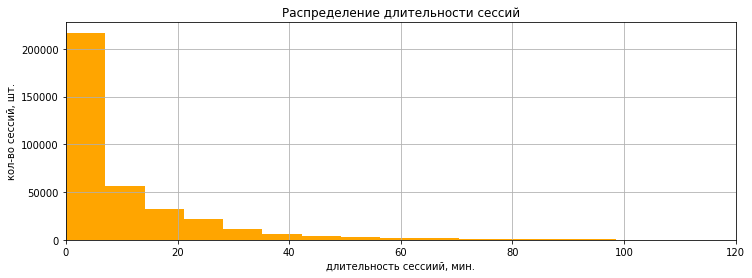

In [49]:
visits['duration_ts_min'].hist(bins=200, figsize=(12,4), color='orange')
plt.xlim(0, 120)
plt.xlabel('длительность сессиий, мин.')
plt.ylabel('кол-во сессий, шт.')
plt.title('Распределение длительности сессий')
plt.show()

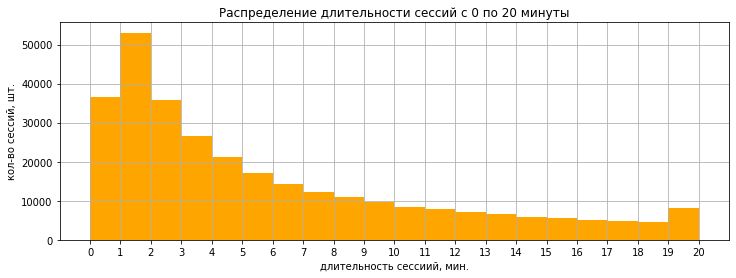

In [50]:
visits.query('0 <= duration_ts_min <= 20').hist('duration_ts_min', bins=20, figsize=(12,4), color='orange')
plt.xlabel('длительность сессиий, мин.')
plt.ylabel('кол-во сессий, шт.')
plt.title('Распределение длительности сессий с 0 по 20 минуты')
plt.xticks(np.arange(0, 21, 1))
plt.show()

In [51]:
print('Доля сессий, длительностью ноль минут:', 
      round(visits[visits['duration_ts_min'] == 0]['duration_ts_min'].count() / len(visits), 2))

Доля сессий, длительностью ноль минут: 0.1


In [52]:
print('Доля сессий, длительностью в минуту:', 
      round(visits[visits['duration_ts_min'] == 1]['duration_ts_min'].count() / len(visits), 2))

Доля сессий, длительностью в минуту: 0.15


Сессий с нулевой продолжительностью почти 10 % от общего числа. Это могут быть как сессии, завершившиеся по техническим причинам (разрыв соединения, ошибки), так и сессии менее 30 секунд, т.к. данные о времени начала и завершения сессий округлены до целых минут. 
Распределение явно асимметрично, использовать среднее для оценки тенденции нельзя. 


In [53]:
print('Средняя продолжительность сессии (медиана): {} мин.'.format(int(round(visits['duration_ts_min'].median(),0))))
print('Средняя продолжительность сессии (мода): {} мин.'.format(int(round(visits['duration_ts_min'].mode(),0))))

Средняя продолжительность сессии (медиана): 5 мин.
Средняя продолжительность сессии (мода): 1 мин.


Сделаем срез по тем пользователям, которые совершили заказы и посмотрим, отличается ли их средняя продолжительность сессий от продолжительности всех посетителей. 

In [54]:
visits_with_order = visits.query('uid in @orders.uid')

In [55]:
print('Кол-во посещений: {}'.format(len(visits)))
print('Кол-во посещений, приведших к заказам: {}'.format(len(visits_with_order)))
print('Конверсия от посещений к покупкам: {:.2%}'.format((len(visits_with_order)/(len(visits)))))

Кол-во посещений: 359400
Кол-во посещений, приведших к заказам: 97393
Конверсия от посещений к покупкам: 27.10%


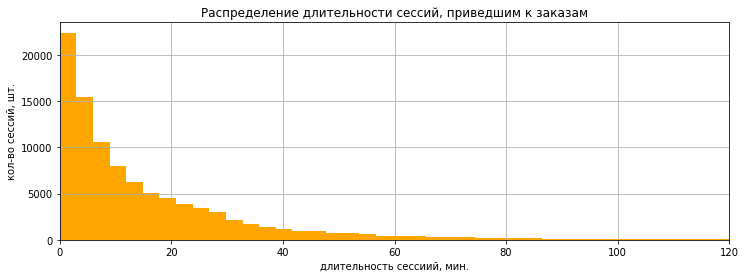

In [56]:
visits_with_order['duration_ts_min'].hist(bins=200, figsize=(12,4), color='orange')
plt.xlim(0, 120)
plt.xlabel('длительность сессиий, мин.')
plt.ylabel('кол-во сессий, шт.')
plt.title('Распределение длительности сессий, приведшим к заказам')
plt.show()

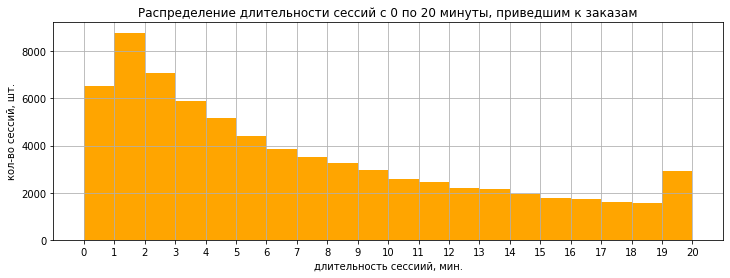

In [57]:
visits_with_order.query('0 <= duration_ts_min <= 20').hist('duration_ts_min', bins=20, figsize=(12,4), color='orange')
plt.xlabel('длительность сессиий, мин.')
plt.ylabel('кол-во сессий, шт.')
plt.title('Распределение длительности сессий с 0 по 20 минуты, приведшим к заказам')
plt.xticks(np.arange(0, 21, 1))
plt.show()

In [58]:
print('Средняя продолжительность сессии (медиана) пользователей, сделавших заказы: {} мин.'
      .format(int(round(visits_with_order['duration_ts_min'].median(),0))))
print('Средняя продолжительность сессии (мода) пользователей, сделавших заказы: {} мин.'
      .format(int(round(visits_with_order['duration_ts_min'].mode(),0))))

Средняя продолжительность сессии (медиана) пользователей, сделавших заказы: 9 мин.
Средняя продолжительность сессии (мода) пользователей, сделавших заказы: 1 мин.


**Вывод**

Половина пользователей тратит более 5 минут на поиски интересующих их мероприятий, а половина "справляется" менее, чем за 5 минут. Чаще всего хватает от минуты до двух. 

Только 27 % визитов приводит к заказам. И те пользователи, которые совершают заказ, склонны проводить на сайте несколько больше времени, в среднем до 9 минут, но по прежнему тех, кто заканчивает сессию до 2х минут - большинство. 

Возможно коллегам стоит уделить внимание более детальному изучению вопроса, почему довольно большое кол-во пользователей "уходят", так и не купив билеты. 

### Retention Rate

In [59]:
# формирование когорты: возьмём месяц, когда пользователь впервые проявил активность

first_visit = visits.groupby('uid')['start_month'].min().reset_index()
first_visit.columns = ['uid', 'first_visit_month']

In [60]:
first_visit.head()

,uid,first_visit_month
0,11863502262781,2018-03-01
1,49537067089222,2018-02-01
2,297729379853735,2017-06-01
3,313578113262317,2017-09-01
4,325320750514679,2017-09-01


In [61]:
# добавим данные о месяце первой активности к таблице `visits`
visits = visits.merge(first_visit, on='uid')

In [62]:
visits.head()

,uid,device,source_id,start_ts,end_ts,start_day,start_week,start_month,duration_ts_min,first_visit_month
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,2017-12-14,2017-12-01,18.0,2017-12-01
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,2018-02-15,2018-02-01,28.0,2018-02-01
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,2018-05-17,2018-05-01,24.0,2018-03-01
4,16174680259334210214,desktop,4,2018-03-09 20:05:00,2018-03-09 20:33:00,2018-03-09,2018-03-08,2018-03-01,28.0,2018-03-01


In [63]:
visits['first_visit_month'].isna().sum()

0

In [64]:
# найдем lifetime, преобразовав timedelta в число месяцев

visits['cohort_lifetime'] = (((visits['start_month'] - visits['first_visit_month']) 
                              / np.timedelta64(1, 'M'))
                             .round()
                             .astype('int'))

In [65]:
visits.head()

,uid,device,source_id,start_ts,end_ts,start_day,start_week,start_month,duration_ts_min,first_visit_month,cohort_lifetime
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,2017-12-14,2017-12-01,18.0,2017-12-01,0
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,2018-02-15,2018-02-01,28.0,2018-02-01,0
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01,0
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,2018-05-17,2018-05-01,24.0,2018-03-01,2
4,16174680259334210214,desktop,4,2018-03-09 20:05:00,2018-03-09 20:33:00,2018-03-09,2018-03-08,2018-03-01,28.0,2018-03-01,0


In [66]:
# группируем данные по когорте `first_visit_month` и lifetime. 
# cчитаем для каждой когорты кол-во активных пользователей на определенный "месяц жизни".

cohort = (visits.groupby(['first_visit_month', 'cohort_lifetime'])
          .agg({'uid': 'nunique'})
          .reset_index()
         )

cohort = cohort.rename(columns={'uid': 'n_uid'})

In [67]:
cohort.head(10)

,first_visit_month,cohort_lifetime,n_uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
5,2017-06-01,5,947
6,2017-06-01,6,809
7,2017-06-01,7,766
8,2017-06-01,8,694
9,2017-06-01,9,674


In [68]:
#находим исходное кол-во пользователей в когорте
initial_users_count = cohort[cohort['cohort_lifetime'] == 0][['first_visit_month', 'n_uid']]

#переименовываем столбец
initial_users_count = initial_users_count.rename(columns={'n_uid': 'cohort_n_uid'})

In [69]:
initial_users_count.head()

,first_visit_month,cohort_n_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [70]:
#добавляем данные из `initial_users_count` в таблицу с когортами `cohort`
cohort = cohort.merge(initial_users_count, on='first_visit_month')

In [71]:
cohort.head()

,first_visit_month,cohort_lifetime,n_uid,cohort_n_uid
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [72]:
#рассчитаем retention rate: делим кол-во активных пользователей в каждый месяц на исходное кол-во пользователей в когорте
cohort['retention'] = (cohort['n_uid'] / cohort['cohort_n_uid']).round(4)

In [73]:
cohort.head()

,first_visit_month,cohort_lifetime,n_uid,cohort_n_uid,retention
0,2017-06-01,0,13259,13259,1.0000
1,2017-06-01,1,1043,13259,0.0787
2,2017-06-01,2,713,13259,0.0538
3,2017-06-01,3,814,13259,0.0614
4,2017-06-01,4,909,13259,0.0686


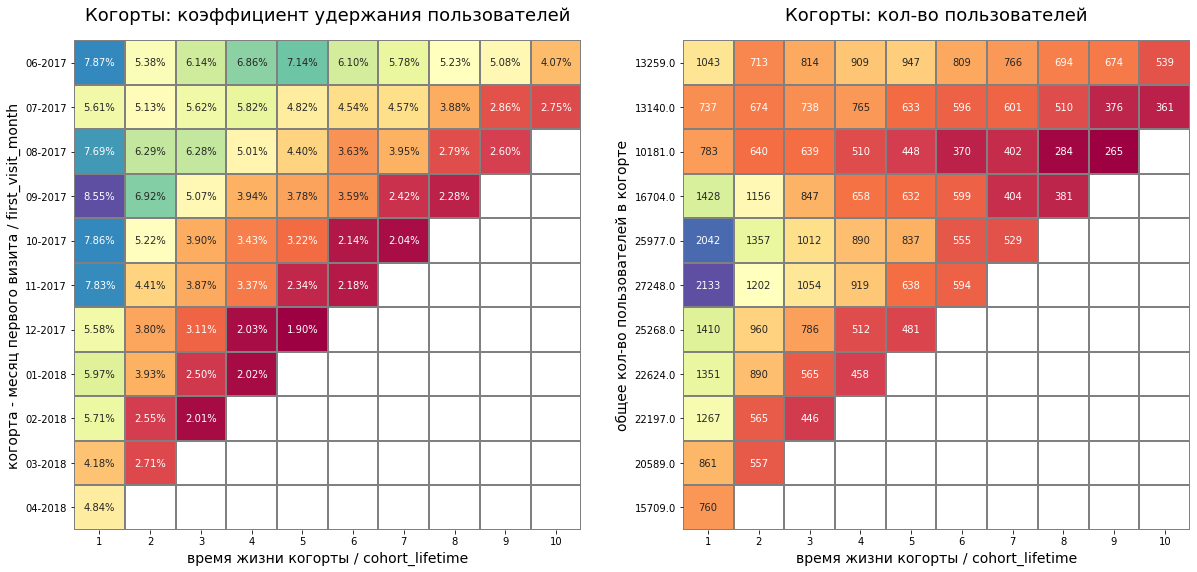

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))

#тепловая карта для retention_rate
sns.heatmap(
    cohort.pivot_table(
    index='first_visit_month', 
    columns='cohort_lifetime', 
    values='retention', 
    aggfunc='sum').iloc[0:11, 1:11], 
    annot=True,
    fmt='.2%',
    linewidths=1,
    linecolor='gray',
    cmap= 'Spectral', 
    cbar=False,
    ax=ax[0]
)

#тепловая карта для кол-ва пользователей
sns.heatmap(
    cohort.pivot_table(
    index='first_visit_month', 
    columns='cohort_lifetime', 
    values='n_uid', 
    aggfunc='sum').iloc[0:11, 1:11], 
    annot=True,
    fmt='g',
    linewidths=1,
    linecolor='gray',
    cmap= 'Spectral',
    #yticklabels=False,
    cbar=False,
    ax=ax[1]
)

ax[0].set_yticklabels(cohort.pivot_table(
    index='first_visit_month', 
    columns='cohort_lifetime', 
    values='retention', 
    aggfunc='sum').index.strftime('%m-%Y'))

ax[1].set_yticklabels(cohort.pivot_table(
    index='first_visit_month', 
    columns='cohort_lifetime', 
    values='n_uid', 
    aggfunc='sum').iloc[0:11, 0])

ax[0].set_title('Когорты: коэффициент удержания пользователей', pad=20, fontsize=18)
ax[1].set_title('Когорты: кол-во пользователей', pad=20, fontsize=18)

ax[0].set_xlabel('время жизни когорты / cohort_lifetime', fontsize=14)
ax[1].set_xlabel('время жизни когорты / cohort_lifetime', fontsize=14)

ax[0].set_ylabel('когорта - месяц первого визита / first_visit_month', fontsize=14)
ax[1].set_ylabel('общее кол-во пользователей в когорте', fontsize=14)

plt.show()


In [75]:
print('Cредний Retention Rate на второй месяц «жизни» когорт: {:.2%}'.format(
    cohort.pivot_table(
    index='first_visit_month', 
    columns='cohort_lifetime', 
    values='retention', 
    aggfunc='sum')[1].mean()))

Cредний Retention Rate на второй месяц «жизни» когорт: 6.52%


**Вывод**

Коэффициент снижается с каждым последующим месяцем жизни когорты, т.е. всё меньше людей вспоминает о нашей "Афише".

Самый высокие коэффициент удержания, около 8 %: в нулевой месяц "жизни" у 1 ("06-2017"), 3-6 ("08-2017" - "11-2017") когорт. Высокую возвращаемость для осенних когорт на первых месяцах "жизни" можно объяснить ростом активности в целом, свойственным для этого времени года, которую мы отмечали ранее при исследовании пользовательских метрик. 

О росте активности пользователей осенью говорит и рост когорт, если в июне 2017 года "пришло" 13 тысяч человек, то в сентябре-октябре уже 26-27 тысяч. 

В связи с этим **наибольший интерес для нас должна представлять 1ая когорта**, т.к. она сохраняет относительно неплохие показатели возвращаемости и в первые месяца жизни, которые приходятся на "низкий" летний сезон и в дальнейшие месяца. 

## Метрики электронной коммерции

### Время до первого заказа

In [76]:
visits.head()

,uid,device,source_id,start_ts,end_ts,start_day,start_week,start_month,duration_ts_min,first_visit_month,cohort_lifetime
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,2017-12-14,2017-12-01,18.0,2017-12-01,0
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,2018-02-15,2018-02-01,28.0,2018-02-01,0
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01,0
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,2018-05-17,2018-05-01,24.0,2018-03-01,2
4,16174680259334210214,desktop,4,2018-03-09 20:05:00,2018-03-09 20:33:00,2018-03-09,2018-03-08,2018-03-01,28.0,2018-03-01,0


In [77]:
#для каждого пользователя найдем время 1го визита и 1го заказа

min_date_visit = visits.groupby('uid')['start_ts'].min().reset_index()
min_date_visit.columns = ['uid', 'first_visit_date']

min_date_buy = orders.groupby('uid')['buy_ts'].min().reset_index()
min_date_buy.columns = ['uid', 'first_buy_date']

In [78]:
min_date_visit.shape[0]

228169

In [79]:
min_date_buy.shape[0]

36522

In [80]:
time_to_buy = min_date_visit.merge(min_date_buy, on='uid')
time_to_buy.head()

,uid,first_visit_date,first_buy_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [81]:
time_to_buy.shape[0]

36522

In [82]:
time_to_buy['time_to_buy_min'] = ((time_to_buy['first_buy_date'] - time_to_buy['first_visit_date']).dt.seconds)/60

In [83]:
time_to_buy.head()

,uid,first_visit_date,first_buy_date,time_to_buy_min
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1382.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


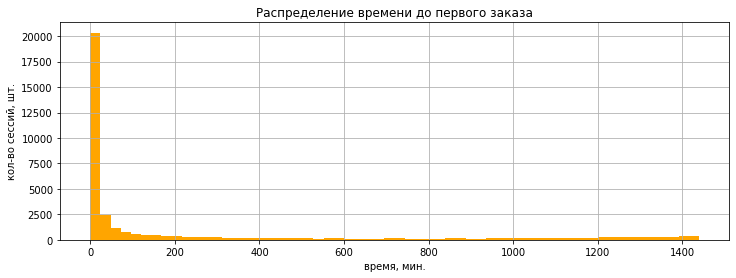

In [84]:
time_to_buy['time_to_buy_min'].hist(bins=60, figsize=(12,4), color='orange')
plt.xlabel('время, мин.')
plt.ylabel('кол-во сессий, шт.')
plt.title('Распределение времени до первого заказа')
plt.show()

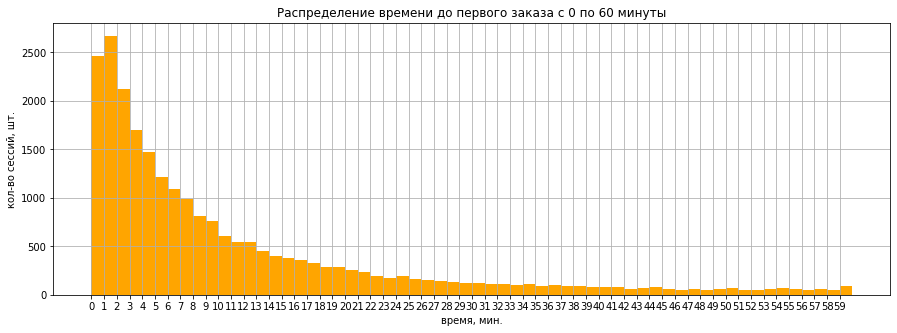

In [85]:
time_to_buy[time_to_buy['time_to_buy_min'] <= 60]['time_to_buy_min'].hist(bins=60, figsize=(15,5), color='orange')
plt.xlabel('время, мин.')
plt.ylabel('кол-во сессий, шт.')
plt.title('Распределение времени до первого заказа с 0 по 60 минуты')
plt.xlim=(0,60)
plt.xticks(np.arange(0, 60, 1))
plt.show()

In [86]:
print('Среднее продолжительности сессии до совершения покупки: {:.2f} мин'.format(time_to_buy['time_to_buy_min'].mean()))
print('Медиана продолжительности сессии до совершения покупки: {:.2f} мин'.format(time_to_buy['time_to_buy_min'].median()))

Среднее продолжительности сессии до совершения покупки: 249.17 мин
Медиана продолжительности сессии до совершения покупки: 16.00 мин


**Вывод**

По гистограмме распределения можно точно сказать, что чаще всего заказ происходит на 2-3 минуте после перехода на сайт.
Половина пользователей делают заказ до 16 минуты сессии. 

### Подготовка данных для расчета среднего кол-ва покупок, среднего чека, LTV

Сформируем месячные когорты.

In [87]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [88]:
visits.head()

,uid,device,source_id,start_ts,end_ts,start_day,start_week,start_month,duration_ts_min,first_visit_month,cohort_lifetime
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,2017-12-14,2017-12-01,18.0,2017-12-01,0
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,2018-02-15,2018-02-01,28.0,2018-02-01,0
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01,0
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,2018-05-17,2018-05-01,24.0,2018-03-01,2
4,16174680259334210214,desktop,4,2018-03-09 20:05:00,2018-03-09 20:33:00,2018-03-09,2018-03-08,2018-03-01,28.0,2018-03-01,0


In [89]:
# выделим месяц из даты в таблице с заказами 
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [90]:
# найдем 1ый месяц покупки для каждого покупателя
first_order = orders.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_order.columns = ['uid', 'first_buy_month']
first_order.head()

,uid,first_buy_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [91]:
# найдем кол-во новых покупателей за каждый месяц
cohort_sizes = first_order.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_uid']
cohort_sizes.head()

,first_buy_month,n_uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [92]:
#добавим в таблицу с заказами месяц 1ой покупки 
orders = pd.merge(orders, first_order, on='uid')
orders.head()

,buy_ts,revenue,uid,buy_month,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [93]:
#сгруппируем таблицу по месяцу 1ой покупки и месяцу каждого заказа, добавим кол-во заказов и их общую сумму 
cohorts_ecom = orders.groupby(['first_buy_month', 'buy_month']).agg({'revenue': ['count', 'sum']}).reset_index()
cohorts_ecom.columns = ['first_buy_month', 'buy_month', 'n_orders', 'sum_revenue']
cohorts_ecom.head()

,first_buy_month,buy_month,n_orders,sum_revenue
0,2017-06-01,2017-06-01,2354,9557.49
1,2017-06-01,2017-07-01,177,981.82
2,2017-06-01,2017-08-01,174,885.34
3,2017-06-01,2017-09-01,226,1931.30
4,2017-06-01,2017-10-01,292,2068.58


In [94]:
#добавим данные о кол-ве покупателей в когортах 
cohorts_ecom = cohorts_ecom.merge(cohort_sizes, on='first_buy_month')
cohorts_ecom.head()

,first_buy_month,buy_month,n_orders,sum_revenue,n_uid
0,2017-06-01,2017-06-01,2354,9557.49,2023
1,2017-06-01,2017-07-01,177,981.82,2023
2,2017-06-01,2017-08-01,174,885.34,2023
3,2017-06-01,2017-09-01,226,1931.30,2023
4,2017-06-01,2017-10-01,292,2068.58,2023


In [95]:
#преобразуем месяц заказа в "возраст" когорты
cohorts_ecom['cohort_lifetime'] = (
    ((cohorts_ecom['buy_month'] - cohorts_ecom['first_buy_month']) / np.timedelta64(1, 'M'))
    .round()
    .astype('int')
                 )

In [96]:
#функция для отрисовки тепловых карт

def heatmap_def(df, figsize, title):
    
    plt.figure(figsize=figsize)
    plt.title(title, pad=20, fontsize=18)
    sns.set(font_scale=1.2)
    ax= sns.heatmap(
        df.round(2),
        annot=True,
        fmt='.3',
        linewidths=1,
        linecolor='gray',
        cmap= 'Spectral'
    )

    ax.set_yticklabels(df.index.strftime('%m-%Y')) # обрезаем когорту-дату в индексе до месяца и года
    plt.xlabel('время жизни когорты', fontsize=14)
    plt.ylabel('когорта - месяц первого заказа', fontsize=14)
    plt.yticks(rotation=0)
    plt.show()

### Среднее кол-во покупок на одного покупателя

In [97]:
#рассчитаем кол-во заказов
cohorts_ecom['orders_per_user'] = cohorts_ecom['n_orders'] / cohorts_ecom['n_uid']
cohorts_ecom.head()

,first_buy_month,buy_month,n_orders,sum_revenue,n_uid,cohort_lifetime,orders_per_user
0,2017-06-01,2017-06-01,2354,9557.49,2023,0,1.163618
1,2017-06-01,2017-07-01,177,981.82,2023,1,0.087494
2,2017-06-01,2017-08-01,174,885.34,2023,2,0.086011
3,2017-06-01,2017-09-01,226,1931.30,2023,3,0.111715
4,2017-06-01,2017-10-01,292,2068.58,2023,4,0.144340


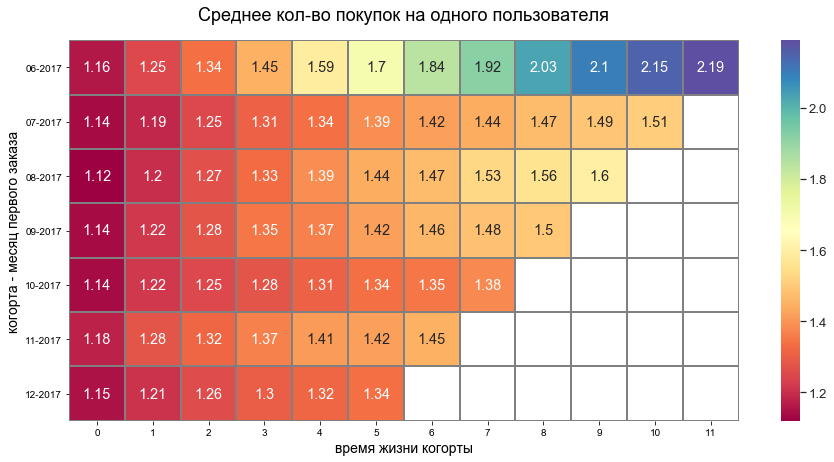

In [98]:
#тепловая карта для среднего кол-ва покупок на одного пользователя
heatmap_def(df = 
             (cohorts_ecom
              .pivot_table(
                  index='first_buy_month', 
                  columns='cohort_lifetime', 
                  values='orders_per_user', 
                  aggfunc='mean')
              .cumsum(axis=1)
              .round(2)[:7]),
             
             figsize =(15, 7),
             title = 'Среднее кол-во покупок на одного пользователя'             
            )

**Вывод**

В основном пользователи не совершают более одной покупки в месяц. Полагаю, что для сервиса по продаже билетов на культурные мероприятия это неплохой показатель. 
Интересно, что показатель постепенно растет с увеличением времени жизни когорот, особенно это заметно на примере 1ой когорты, которую мы уже выделяли при анализе Retention Rate.

### Средний чек

Посмотрим насколько сильно будут отличаться показатели среднего чека при расчете с делением на когорты и группировке по времени совершения покупки, действительно ли когортный анализ исказит результаты. 

In [99]:
#рассчитаем средний чек
cohorts_ecom['revenue_per_user'] = cohorts_ecom['sum_revenue'] / cohorts_ecom['n_uid']
cohorts_ecom.head()

,first_buy_month,buy_month,n_orders,sum_revenue,n_uid,cohort_lifetime,orders_per_user,revenue_per_user
0,2017-06-01,2017-06-01,2354,9557.49,2023,0,1.163618,4.724414
1,2017-06-01,2017-07-01,177,981.82,2023,1,0.087494,0.485329
2,2017-06-01,2017-08-01,174,885.34,2023,2,0.086011,0.437637
3,2017-06-01,2017-09-01,226,1931.30,2023,3,0.111715,0.954671
4,2017-06-01,2017-10-01,292,2068.58,2023,4,0.144340,1.022531


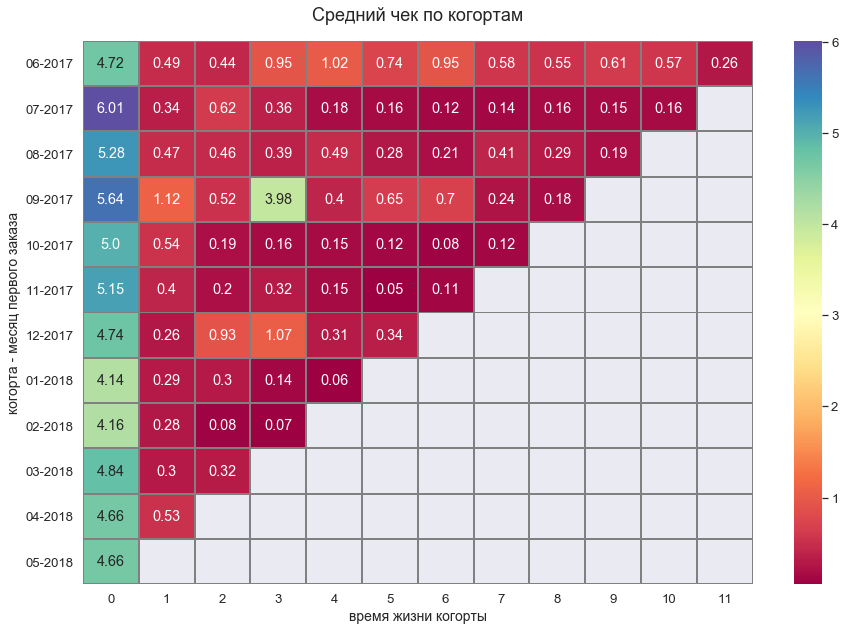

In [100]:
#тепловая карта для среднего чека
heatmap_def(df = 
             (cohorts_ecom
              .pivot_table(
                  index='first_buy_month', 
                  columns='cohort_lifetime', 
                  values='revenue_per_user', 
                  aggfunc='median')
              .round(2)),
             
             figsize =(15, 10),
             title = 'Средний чек по когортам'             
            )

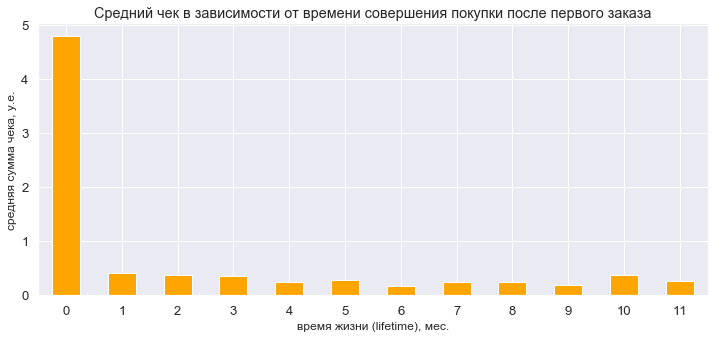

In [101]:
(cohorts_ecom
 .pivot_table(
     index='cohort_lifetime', 
     values='revenue_per_user', 
     aggfunc='median')
 .plot(kind='bar', grid=True, figsize=(12, 5), legend=False, rot=0.9, color='orange',
       title='Средний чек в зависимости от времени совершения покупки после первого заказа'))

plt.xlabel('время жизни (lifetime), мес.', fontsize=12)
plt.ylabel('средняя сумма чека, y.e.', fontsize=12)
plt.title
plt.show()

**Вывод** 

Результаты и по когортному анализу и по расчету среднего чека в зависимости от времени совершения покупки идентичны, самый высокий показатель в первый месяц посещения ресурса - около 5 y.e. Со следующего месяца резкое снижение суммы заказа на покупателя, средний чек не достигает и 1 y.e. 

In [102]:
orders.head()

,buy_ts,revenue,uid,buy_month,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


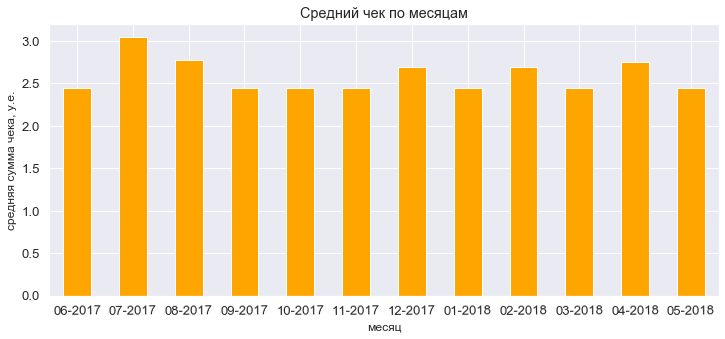

In [103]:
avg_revenue_per_user_ver2 = orders.pivot_table(index='buy_month', values='revenue', aggfunc='median')
avg_revenue_per_user_ver2.index = avg_revenue_per_user_ver2.index.strftime("%m-%Y") 
 
avg_revenue_per_user_ver2.plot(kind='bar', grid=True, figsize=(12, 5), legend=False, rot=0.9, color='orange',
                      title='Средний чек по месяцам')

plt.xlabel('месяц', fontsize=12)
plt.ylabel('средняя сумма чека, y.e.', fontsize=12)
plt.title
plt.show()

**Вывод**

Если не брать во внимание деление покупателей на когорты, то все вместе тратят примерно по 2,5 y.e. на пользователя.

### LTV

In [104]:
cohorts_ecom.head()

,first_buy_month,buy_month,n_orders,sum_revenue,n_uid,cohort_lifetime,orders_per_user,revenue_per_user
0,2017-06-01,2017-06-01,2354,9557.49,2023,0,1.163618,4.724414
1,2017-06-01,2017-07-01,177,981.82,2023,1,0.087494,0.485329
2,2017-06-01,2017-08-01,174,885.34,2023,2,0.086011,0.437637
3,2017-06-01,2017-09-01,226,1931.30,2023,3,0.111715,0.954671
4,2017-06-01,2017-10-01,292,2068.58,2023,4,0.144340,1.022531


Маржинальность нашего сервиса - фантастические 100 %, поэтому валовая прибыль будет равна нашему доходу, т.е. данным по столбцу `sum_revenue`. 

LTV результат деления нашего дохода на кол-во пользователей в когорте, т.е. для нашего случая это средний доход от одного пользователя или средний чек, который мы считали ранее. Остается только сгруппировать данные накопительным итогом, т.к. LTV - накопительная метрика, в отличие от "среднего чека" и "удалить" когорты, "прожившие" менее 6 месяцев.

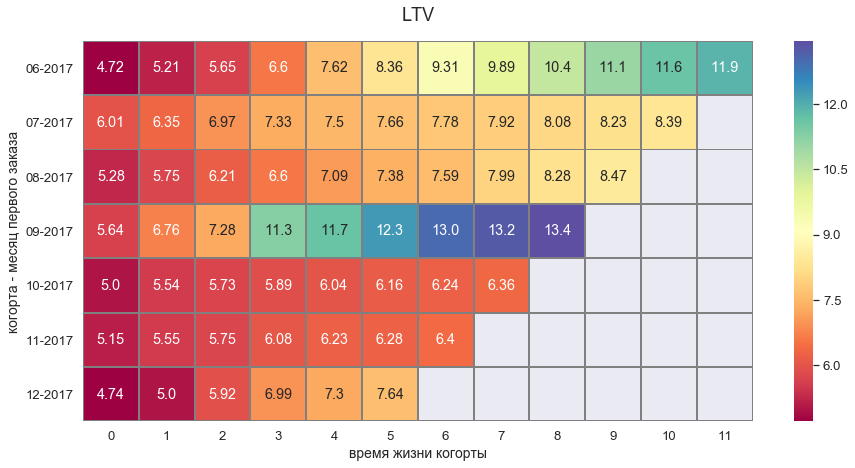

In [105]:
#тепловая карта для LTV
heatmap_def(df = 
             (cohorts_ecom
              .pivot_table(
                  index='first_buy_month', 
                  columns='cohort_lifetime', 
                  values='revenue_per_user', 
                  aggfunc='mean')
              .cumsum(axis=1).round(2)[:7]),
             
             figsize =(15, 7),
             title = 'LTV'             
            )

**Вывод**

Самый высокие показатели LTV у 4 когорты "09-2017", также неплохие показатели у 1ой когорты "06-2017", хотя они и ниже почти на треть, 12,3 и 8,3 y.e. на 6 месяц существования, соответственно.

## Маркетинговые метрики

In [106]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [107]:
visits.head()

,uid,device,source_id,start_ts,end_ts,start_day,start_week,start_month,duration_ts_min,first_visit_month,cohort_lifetime
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,2017-12-14,2017-12-01,18.0,2017-12-01,0
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,2018-02-15,2018-02-01,28.0,2018-02-01,0
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01,0
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,2018-05-17,2018-05-01,24.0,2018-03-01,2
4,16174680259334210214,desktop,4,2018-03-09 20:05:00,2018-03-09 20:33:00,2018-03-09,2018-03-08,2018-03-01,28.0,2018-03-01,0


### Общая сумма расходов на маркетинг

In [108]:
print('Всего расходов на маркетинг с {} по {}: {} y.e.'.format(
    costs['dt'].min().strftime('%Y-%m'),
    costs['dt'].max().strftime('%Y-%m'),
    costs['costs'].sum()
))

Всего расходов на маркетинг с 2017-06 по 2018-05: 329131.62 y.e.


In [109]:
costs.groupby('source_id').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


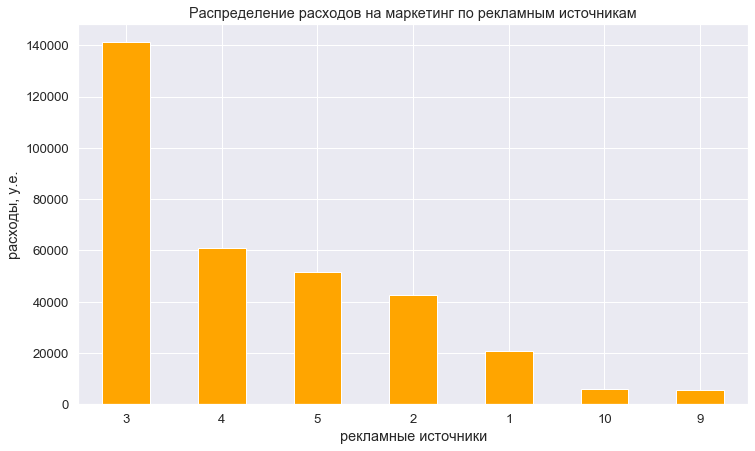

In [110]:
(costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
 .sort_values(by='costs', ascending=False)
 .plot(kind='bar', x='source_id', y='costs', figsize=(12, 7), color='orange', legend=False, rot=0))

plt.xlabel('рекламные источники')
plt.ylabel('расходы, y.e.')
plt.title('Распределение расходов на маркетинг по рекламным источникам')
plt.show()

In [111]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [112]:
costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


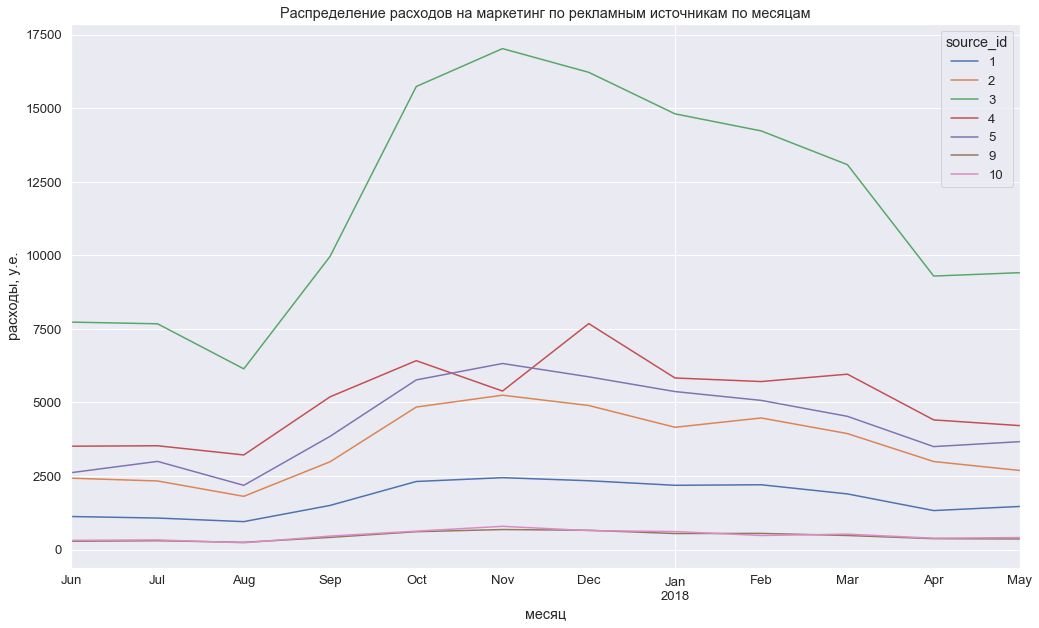

In [113]:
costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').plot(figsize=(17, 10))

plt.xlabel('месяц')
plt.ylabel('расходы, y.e.')
plt.title('Распределение расходов на маркетинг по рекламным источникам по месяцам')
plt.show()

**Вывод**

Всего на маркетинг было потрачено 329 тысяч y.e., из них:

    - 140 тысяч (42%) было вложено в рекламный источник № 3, 
    
    - 60 тысяч (18%) - в источник № 4 и 
    
    - порядка 50 тысяч (15%) - № 5. 
    
    Так же выделялись деньги на привлечение пользователей из источников № 2 и 1. 
    
    9 и 10 источники почти не финансировались, на них выделили по 5 тысяч за весь год. 
    
Расходы на рекламу по всем источникам начинают увеличиваться с августа 2017 года и уменьшаются с начала 2018 года. Максимальные вливания в рекламу были в ноябре-декабря. В это же время пользователи показывают самую высокую активность в течение года.   

### средний CAC на одного покупателя

In [114]:
orders.head()

,buy_ts,revenue,uid,buy_month,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [115]:
orders = orders.rename(columns = {'buy_month': 'month'})

In [116]:
#столбцы, по которым группируем 
group_demensions = ['month', 'source_id']
#group_demensions = ['source_id']

In [117]:
#группировка расходов на маркетинг по источнику и месяцу
costs_group = costs.groupby(group_demensions).agg({'costs': 'sum'})
costs_group

costs
month      source_id         
2017-06-01 1          1125.61
           2          2427.38
           3          7731.65
           4          3514.80
           5          2616.12
...                       ...
2018-05-01 3          9411.42
           4          4214.21
           5          3669.56
           9           362.17
           10          409.86

[84 rows x 1 columns]

In [118]:
#найдем "главный" (первый) источник перехода и первый месяц для каждого пользователя
visits_group = (visits.sort_values(by=['uid', 'start_ts'])
                .groupby(['uid']).agg({'source_id': 'first', 'first_visit_month': 'first'}).reset_index())
visits_group.columns = ['uid', 'source_id', 'month']
visits_group.head()

,uid,source_id,month
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-01
2,297729379853735,3,2017-06-01
3,313578113262317,2,2017-09-01
4,325320750514679,5,2017-09-01


In [119]:
#отбираем из посетителей только плательщиков
buyers = visits_group.query('uid in @orders.uid')
buyers.head()

,uid,source_id,month
3,313578113262317,2,2017-09-01
22,1575281904278712,10,2017-06-01
35,2429014661409475,3,2017-10-01
36,2464366381792757,5,2018-01-01
38,2551852515556206,5,2017-11-01


In [120]:
#находим кол-во покупателей для каждого месяца и источника
buyers = buyers.groupby(group_demensions).agg({'uid': 'nunique'})
buyers

uid
month      source_id     
2017-06-01 1          240
           2          374
           3          886
           4          647
           5          509
...                   ...
2018-05-01 3          624
           4          610
           5          406
           9           30
           10         101

[85 rows x 1 columns]

In [121]:
#добавляем данные о затратах на каждый источник
report = buyers.join(costs_group)
report

uid    costs
month      source_id              
2017-06-01 1          240  1125.61
           2          374  2427.38
           3          886  7731.65
           4          647  3514.80
           5          509  2616.12
...                   ...      ...
2018-05-01 3          624  9411.42
           4          610  4214.21
           5          406  3669.56
           9           30   362.17
           10         101   409.86

[85 rows x 2 columns]

In [122]:
report['cac_cost_per_buyer'] = report['costs'] / report['uid']
report = report.reset_index()
report.head()

,month,source_id,uid,costs,cac_cost_per_buyer
0,2017-06-01,1,240,1125.61,4.690042
1,2017-06-01,2,374,2427.38,6.490321
2,2017-06-01,3,886,7731.65,8.726467
3,2017-06-01,4,647,3514.80,5.432457
4,2017-06-01,5,509,2616.12,5.139725


In [123]:
cac_for_each_source = report.pivot_table(index='source_id', values=['uid', 'costs'], aggfunc='sum')
cac_for_each_source['cac_for_each_source'] = (cac_for_each_source['costs'] / cac_for_each_source['uid']).round(2)
print('Средний CAC на одного покупателя для каждого источника трафика (y.e.):')
cac_for_each_source['cac_for_each_source'].sort_values(ascending=False).to_frame()

Средний CAC на одного покупателя для каждого источника трафика (y.e.):


,cac_for_each_source
source_id,
3,13.49
2,12.21
5,7.47
1,7.19
4,5.93
9,5.07
10,4.38
7,0.00


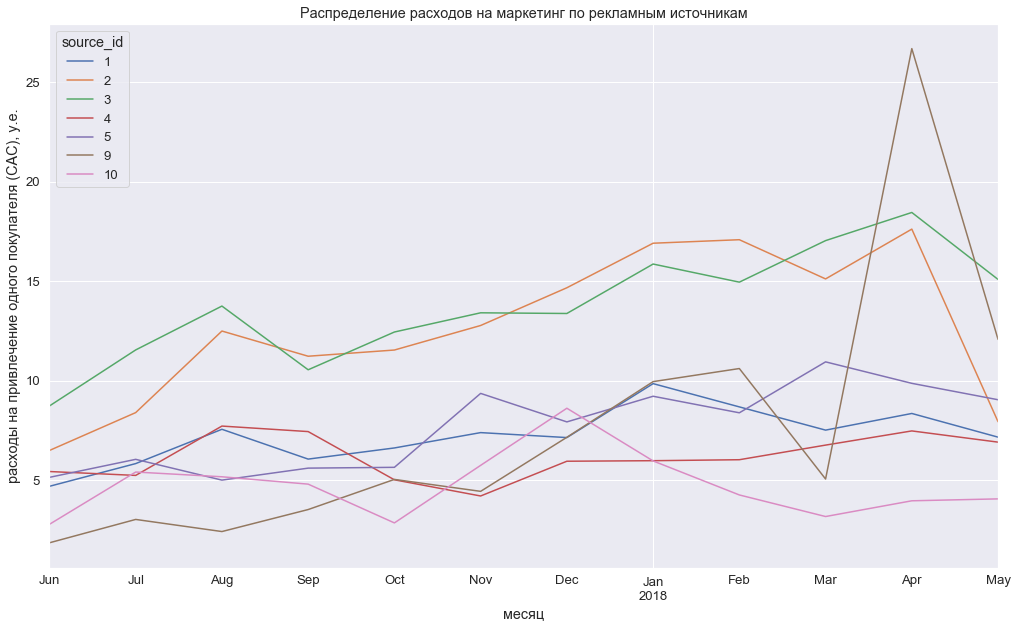

In [124]:
report.pivot_table(index='month', columns='source_id', values='cac_cost_per_buyer', aggfunc='mean').plot(figsize=(17, 10))


plt.xlabel('месяц')
plt.ylabel('расходы на привлечение одного покупателя (CAC), y.e.')
plt.title('Распределение расходов на маркетинг по рекламным источникам')
plt.show()

In [125]:
print('Средний CAC на одного покупателя для всего проекта: {} y.e.'
      .format((report['costs'].sum() / report['uid'].sum()).round(2)))

Средний CAC на одного покупателя для всего проекта: 9.01 y.e.


**Вывод**

Средняя стоимость привлечения одного пользователя составила 9 y.e. 

Самыми дорогими оказались клиенты, пришедшие из 2 и 3 источников, причем стоимость их привлечения расчет начиная с начала исследуемого периода. Из 2го источника явно "приходит" мало пользователей, т.к. расходы на этот источник невысокие, а САС сравним с САС для 3го источника, в продвижение которого была вложена наибольшая сумма. 

На общем фоне не слишком привлекательным выглядит 9 источник, весь год САС растет, к концу исследуемого периода резкий скачок. То ли из-за снижения расходов на этот источник кол-во пользователей становится меньше, то ли наоборот, мы снижаем расходы на слишком перспективный источник "трафика". 

Остальные источники не показывают сильного роста или значительных колебаний. 

### ROMI по когортам в разрезе источников

In [126]:
#функция для расчета LTV, CAC, ROMI по когортам-месяцам заказа и рекламным источникам 
def romi(source):
    try:
        
        #отбираем только плательщиков из нужного источника
        source_users = visits_group.query('source_id == @source')
        source_orders = orders.query('uid in @source_users.uid')

        if len(source_users.index) == 0:
            print('Не было визитов для рекламного источника {}'.format(source))
        else:

            if len(source_orders.index) == 0:
                print('Не было заказов для рекламного источника {}'.format(source))
            else:

                #считаем LTV
                cohorts_sizes = source_orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
                cohorts_sizes.columns = ['first_buy_month', 'n_buyers']

                cohorts = source_orders.groupby(['first_buy_month', 'month']).agg({'revenue': 'sum'}).reset_index()
                report_ltv = pd.merge(cohorts_sizes, cohorts, on='first_buy_month')
                margine_rate = 1.0
                report_ltv['gp'] = report_ltv['revenue'] * margine_rate
                report_ltv['cohort_lifetime'] = (((report_ltv['month'] - report_ltv['first_buy_month']) 
                                                  / np.timedelta64(1, 'M'))
                                                 .round()
                                                 .astype('int'))
                report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers']
                output_ltv = report_ltv.pivot_table(
                    index='first_buy_month', 
                    columns='cohort_lifetime', 
                    values='ltv', 
                    aggfunc='mean'
                )
                output_ltv = output_ltv.cumsum(axis=1).fillna(0)

                #считаем CAC
                source_costs = costs.query('source_id == @source')

                if len(source_costs.index) == 0:
                    print('Не было расходов на рекламу для рекламного источника {}'.format(source))
                else:

                    source_costs = source_costs.groupby('month').agg({'costs': 'sum'})
                    source_costs = source_costs.join(cohorts_sizes.set_index('first_buy_month'))
                    source_costs['cac'] = source_costs['costs'] / source_costs['n_buyers']

                    #считаем ROMI
                    #output_ltv.div(source_costs['cac'], axis=0)

                    #рисуем тепловую карту 
                    heatmap_def(
                        df = output_ltv.div(source_costs['cac'], axis=0), 
                        figsize =(12, 7), 
                        title = 'ROMI для рекламного источника {}'.format(source)             
                            )
                    
    except:
        print('Что-то пошло не так')


Посмотрим какие источники рекламы привели в нам пользователей: 

In [127]:
visits['source_id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10], dtype=int64)

И на какие источники рекламы мы тратили деньги в исследуемом периоде:

In [128]:
costs['source_id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  9, 10], dtype=int64)

Не все источники рекламы финансировались в исследуемом периоде, возьмем более широкий, который получили из таблицы `costs`

In [129]:
source_list = [ 1,  2,  3,  4,  5,  6, 7, 9, 10]

#тепловые карты ROMI сразу через цикл:
#for source in source_list:
    #romi(source)

Можно выводить все тепловые карты ROMI сразу через цикл, но мы выведем отдельно, чтобы удобнее было читать выводы по каждому источнику:

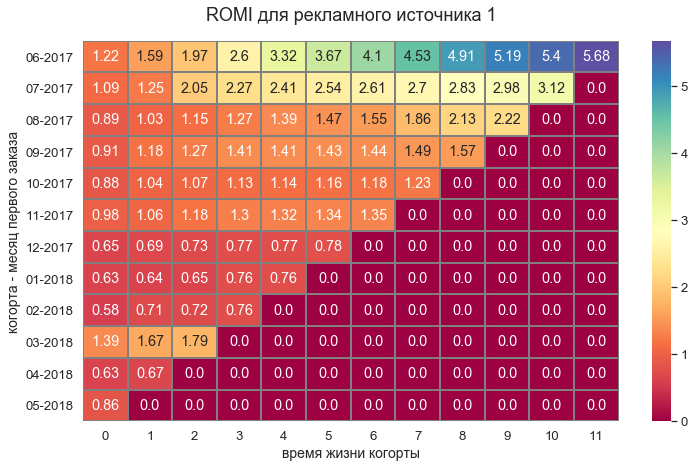

In [130]:
romi(1)

Первый источник выглядит очень убедительно, ROMI растет по всем когортам, т.е. расходы на рекламу окупаются привлеченными клиентами. 

Из минусов можно отметить довольно длительный срок окупаемости для некоторых когорт, ROMI для когорт "12-2017", "01-2018" всё еще довольно далек от единицы, но возможно, что для этих когорт хорошо сработал какой-то другой источник рекламы. 

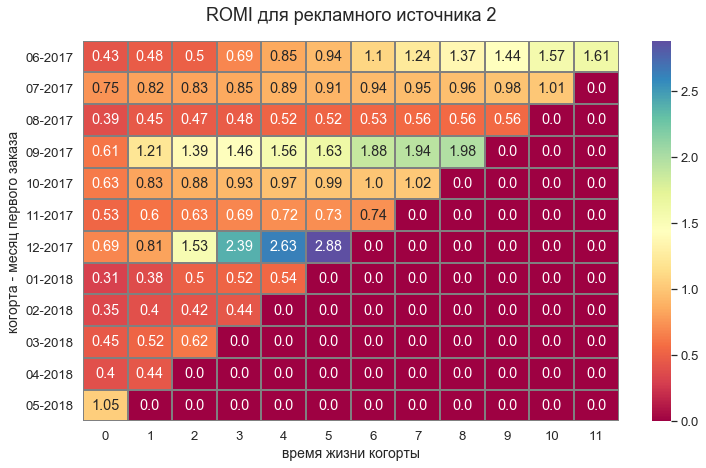

In [131]:
romi(2)

Второй источник интересен тем, что по некоторым когортам ROMI растет быстрее, чем по другим, например, "09-2017", "12-2017". По остальным когортам результаты более скромные, но неплохие, постепенно источник окупает себя. 

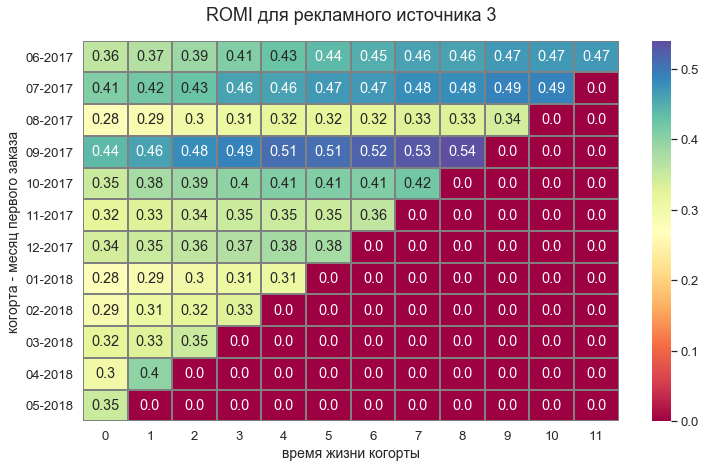

In [132]:
romi(3)

Пока что источник убыточен, на него было потрачена самая большая часть нашего рекламного бюджета. Рост окупаемости низкий. Вложения не окупили даже для 1ой когорты за год. 

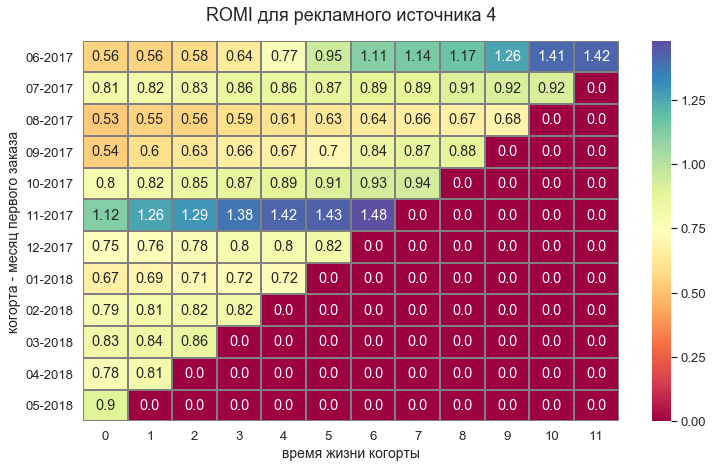

In [133]:
romi(4)

Четвертый источник - второй по затраченным на рекламу средствам, но в отличие от 3го источника, в данном случае расходы на рекламу оправдались хотя бы для некоторым когорт, темп рост ROMI дает нам основания полагать, что в худшем случае за год данный источник окупит себя. 

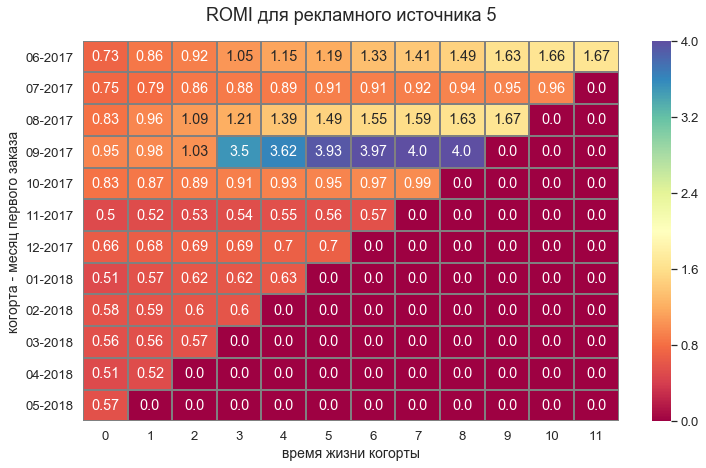

In [134]:
romi(5)

Источник аналогичен четвертому источнику, в него было вложено 15 % бюджета на маркетинг, окупаемость в первых когортах растет быстрее, чем в более поздних, начиная с "11-2017". Нужно изучить причины такого поведения. 

In [135]:
romi(6)

Не было заказов для рекламного источника 6


In [136]:
romi(7)

Не было расходов на рекламу для рекламного источника 7


In [137]:
romi(8)

Не было визитов для рекламного источника 8


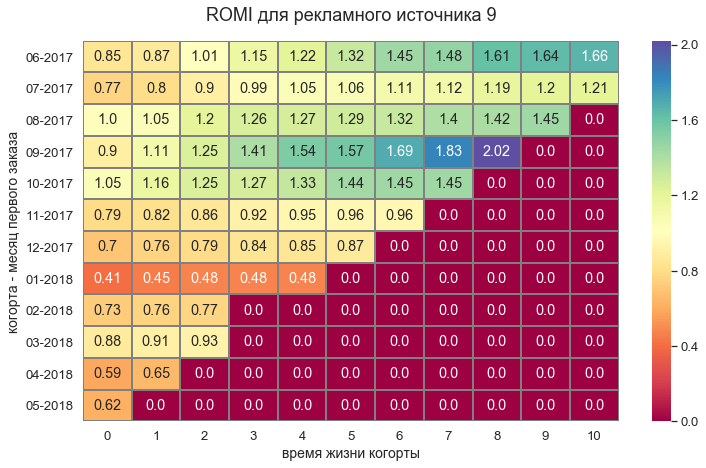

In [138]:
romi(9)

Девятый источник можно отнести к "удачным" источникам рекламы. При низких затратах на рекламу обеспечивает приток посетителей достаточный для того, чтобы отбить эти затраты. 

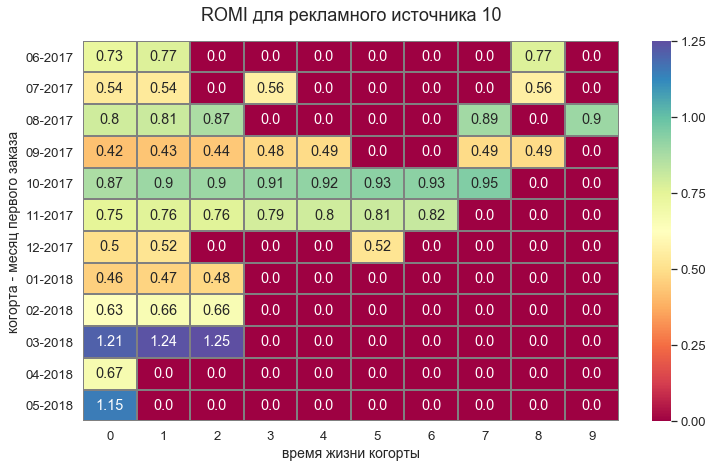

In [139]:
romi(10)

На фоне девятого источника десятый выглядит неубедительно, при аналогичных затратах на маркетинг окупаемость далека от желаемой. Возможно, что это какой-то новый "экспериментальный" источник, т.к. для некоторых когорт он всё таки "выстрелил", причем сразу же с первых месяцев (когорты "03-2018" и "05-2018"). Возможно стоит подумать над доработкой маркетинговой политики по этому источнику. 

# Выводы и рекомендации

В основном пользователи заходят на “Афишу” не чаще одного раза в день и проводят на сайте в среднем до 9 минут, но чаще одну-две. Причем далеко не все сессии заканчиваются покупкой. Стоит обратить внимание, что может мешать пользователям совершить покупку?

Чаще всего пользователи делают заказ на 2-3 минуте после перехода на сайт. Половина пользователей делают заказ до 16 минуты сессии.

**Наибольший интерес с точки зрения удержания пользователей представляет 1ая когорта**, т.к. она сохраняет относительно неплохие показатели возвращаемости и в первые месяца жизни, которые приходятся на "низкий" летний сезон и в дальнейшие месяца в то время как остальные когорты демонстрируют стабильный спад возвращаемости примерно на 1,5 % пункта каждый месяц.

В среднем покупают билеты на чаще одного раза в месяц. Коэффициент постепенно растет, например, в 1ой когорте с 8го месяца “жизни” и далее среднее кол-во покупок выросло до 2, но радоваться этому не стоит, т.к. средний чек уменьшился. 
Средний чек - 2,5 y.e. 

Самый высокие показатели LTV у 4 когорты "09-2017", также неплохие показатели у 1ой когорты "06-2017", хотя они и ниже почти на треть, 12,3 и 8,3 y.e. на 6 месяц существования, соответственно. **Стоит обратить внимание на 1ую и 4ую когорты, они выглядят наиболее многообещающими для "Афиши".**


На рекламу потратили 329 тысяч y.e. год, из них более 40 % (140 000 y.e.) было потрачено на развитие 3 рекламного источника, 18 и 15 % (60 000 и 50 000 y.e.)  было направлено на 4 и 5 рекламные источники.

Увеличение расходов на рекламу совпадает с временем наибольшей активности пользователей и относится ко 2ой половине года (с августа по декабрь). 

Самые "дорогие" пользователи - пришедшие из 2 и 3 источников рекламы. САС растет с 6-7 y.e. до 17-18 y.e. 

Причем, если на 3ий источник и денег на рекламу мы потратили больше всего, то 2ой источник видимо является не слишком популярным у пользователей, т.к. расходов на рекламу на него выделялось порядка 40 000 y.e.


**Лучший рекламный источники: № 1, 2** - довольно высокий и стабильно растущий показатель ROMI, более скромный по темпу роста, но также стабильный ROMI у **9го источника**. 

**Убыточный: 3 источник, очень медленный рост окупаемости**. Стоит подумать о целесообразности вкладывания в него таких денег. 

**Дополнительно изучить когорты в источниках 4 и 5**, по которым высокий темпом роста ROMI, а по остальным когортам окупаемость растет, но не слишком быстро. Возможно с когортах с высоким приростом ROMI проводилась рассылка каких-то спец предложений или были предоставлены скидки. 

Странный 10 источник, интересно было бы узнать почему в 10 и 12 когортах ROMI сразу оказался выше единицы, т.е. расходы на маркетинг окупились в первые же месяцы. 


В целом необходимо пересмотреть маркетинговую политику по источникам, иначе даже при маржинальности в 100 %, мы рискуем потратить все деньги, но не окупиться. 